# Import the Python Modules to Use

In [81]:
import numpy as np               #this lets up handles arrays of data
import collections               #this is for managing dictionaries
import matplotlib.pyplot as plt  #this is for plotting

Flux through a membrane is represented by: $J=\frac{Pe}{x}\Delta P^{1/2}$. \
Justin has provided $J$ and $P^{1/2}$ data for flux through a palladium disk. \
This data should be linear with a slope of $\frac{Pe}{x}$. \
Where $Pe$ is permiability, and $x$ is the thickness of the disk.
We need to solve for the slope, and multiply by the thickness of the disk to get $Pe$, which will then be used in an Arrhenius plot.

# Loading the Data
First, read the data from a csv file. \
There are many ways to do this, will just use numpy to read it. 

In [15]:
d = np.loadtxt('justins_lame_data.csv',delimiter=',').astype(float)

# Parse Out the Data
Here I will split the x data and y data into separate dictionaries. \
The keys for each dictionary will be the temperatures used in the experiment. \
We want to find a linear equation for each temperature. 

In [66]:
xdata = collections.defaultdict(list)
ydata = collections.defaultdict(list)
for line in d:
    xdata[line[0]].append(line[1])
    ydata[line[0]].append(line[2])

Here is an example of what that data looks like:

In [73]:
print('Flux \t\t P^(1/2)')
for x,y in zip(xdata[160],ydata[160]):
    print('{0} \t {1}'.format(x,y))

Flux 		 P^(1/2)
70.72029688 	 0.00923043
86.58709723 	 0.012430882
96.59360351 	 0.013858702
111.3394788 	 0.015268746
133.1379932 	 0.019954319
145.5280828 	 0.02240817
144.750151 	 0.020228152
171.0906187 	 0.02581468
185.4129478 	 0.028842153


## Now lets trying plotting the data. 
We will loop through calling the x and y data for each temperature studied. Add that data to a plot. \
After the loop is done, we can set some graph details (labels and legend), and then tell Python to show us that graph. 

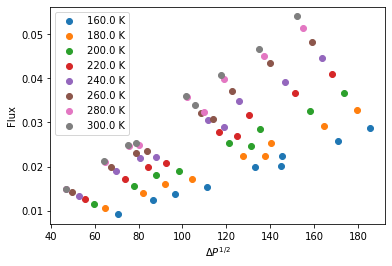

In [85]:
# the keys are the temperatures
# we will iterate over each temperature
keys = xdata.keys() 
for k in keys:
    xvals = np.array(xdata[k]).astype(float) 
    yvals = np.array(ydata[k]).astype(float)
    plt.scatter(xvals,yvals,marker='o',label='{0} K'.format(k))
plt.xlabel('$\Delta P^{1/2}$')
plt.ylabel('Flux')
plt.legend()
plt.show()


## Now Let's Fit a Linear Equation to Each Data Set
We have to define what form the ideal function will look like. \
Remember for a linear function it should be in the form of $y=mx+b$. \
The curve fitting will be done by the SciPy Python Module.

In [80]:
from scipy.optimize import curve_fit

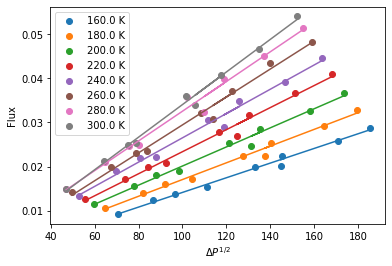

In [89]:
# our function is the linear equation
# SciPy will find m and b to make the lines fit the data automatically
def func(x, m, b):
    return m*x + b

keys = xdata.keys()
temps = []
slopes = []
for k in keys:
    xvals = np.array(xdata[k]).astype(float)
    yvals = np.array(ydata[k]).astype(float)
    
    # this will plot the original data points
    plt.scatter(xvals,yvals,label='{0} K'.format(k))
    
    # popt contains [m,b]
    popt, pcov = curve_fit(func,xvals,yvals)
    
    # this will plot the linear fits
    plt.plot(xvals,func(xvals,*popt))
    
    # we want to store the temperatures in a special variable
    temps.append(k)
    # we don't care about b, here but will store m in a variable called 'slopes'
    slopes.append(popt[0])

plt.xlabel('$\Delta P^{1/2}$')
plt.ylabel('Flux')
plt.legend()
plt.show()

So now that we have slope from each line, we can calculate the permeability at each temperature. Where $Pe = slope*x$ \
Remember that $x =$ thickness, which is 2.5e-5 m in this case. \
Justin would continue to make an Arrhenius plot of $Pe$ vs $\frac{1}{T}$, but we won't do that here.

In [103]:
x = 2.5e-5
print('Temp \t Pe')
for t,s in zip(temps,slopes):
    print('{0:.0f} K \t {1}'.format(t,s))

Temp 	 Pe
160 K 	 4.152718761681018e-09
180 K 	 4.735605325630848e-09
200 K 	 5.407352793321957e-09
220 K 	 6.244891757443774e-09
240 K 	 6.878697406080013e-09
260 K 	 7.909164645248365e-09
280 K 	 8.410821360753707e-09
300 K 	 9.229681495547886e-09


# Catalysis Mechanism Data

Here we have been provided site time yield data for ethylene oligomerization over H-Ni-zeolites. We believe that C$_{4}$ formation takes place at the nickel, while C$_{5}$ requires a C$_{4}$ to be made first, and then a cracking reaction at an acid site to form C$_{3}$. We can test this by fitting the data to a hyperbolic function.

In [272]:
# first grab the data
# we want to skip the first row, because it has header information
# i'm skipping the next 3 rows, 
# because time on stream data doesn't usually look good at first
data = np.loadtxt('h-ni-z_data.csv',delimiter=',',skiprows=4)

In [273]:
# spli the data up into separate arrays
time = data[:,0]
c4 = data[:,1]
c5 = data[:,2]

Let's trying plotting it and see how the data looks.

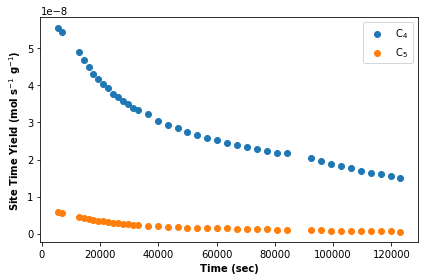

In [274]:
plt.scatter(time,c4,label='C$_{4}$')
plt.scatter(time,c5,label='C$_{5}$')
plt.xlabel('Time (sec)',weight='bold')
plt.ylabel('Site Time Yield (mol s$^{-1}$ g$^{-1}$)',weight='bold')
plt.tight_layout()
plt.legend()
plt.show()

## Fitting the Data
Now we have two different functions we can try to fit the data to. \
We will try both for each product and check the R$^2$ value to see which is best. \
The first function is a hyperbolic or apparent catalytic deactivation: 
### $Y = \frac{Y_{0}}{[1+(n-1)k_{d}Y_{0}^{n-1}t]^{(\frac{1}{n-1})}}$
If this model doesn't fit (R$^{2}$ < 0.97), then we will use an exponential decay model:
### $\frac{dY}{dt}=-k_{d}Y^n$
In both cases, the value we really want to solve for is $n$. \
Different values of $n$ for the species will tell us that the mechanisms are different. 

In [275]:
def funcapp(x,y0,k,n):
    return(y0/((1+(n-1)*k*(y0**(n-1))*x)**(1/(n-1))))
def expdec(x,y0,k):
    return (y0*np.exp(-k*x))

We will start with C$_4$ and check both models. But we need to scale the data to get the best use of curve_fit.

In [276]:
c4 = data[:,1]
scale4 = max(c4)
c4/=scale4

Here we are actually getting fitting parameters.

In [277]:
popt4_1, pcov1 = curve_fit(funcapp, time, c4,p0=(float(c4[0]), 0.0001, 2), bounds=((0,0, 1),(c4[0]*10+0.001,np.inf,5)))

In [278]:
popt4_2, pcov2 = curve_fit(expdec,time, c4, p0=(float(c4[0]), 0.0001), bounds=((0,0),(c4[0]*10+0.001,np.inf)))

Now let's get the R$^2$ values.

In [279]:
# r^2 for funcapp
residuals = c4 - funcapp(time,*popt4_1)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((c4-np.mean(c4))**2)
r1 = 1-(ss_res / ss_tot)

# r^2 for expdec
residuals = c4 - expdec(time,*popt4_2)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((c4-np.mean(c4))**2)
r2 = 1-(ss_res / ss_tot)


Here we will just do some fancy plotting to actually set the fits, and print the R$^2$ values. 

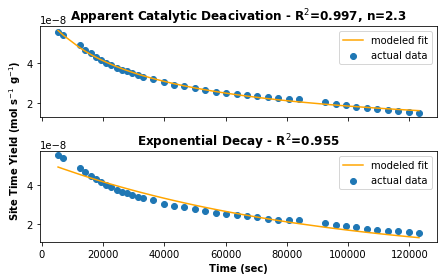

In [280]:
fig,[ax1,ax2] = plt.subplots(2,1,sharex=True)


ax1.plot(time,funcapp(time,*popt4_1)*scale4,label='modeled fit',color='orange')
ax1.scatter(time,c4*scale4,label='actual data')
ax1.set_title('Apparent Catalytic Deacivation - R$^2$={0:.3f}, n={1:.1f}'.format(r1,popt4_1[-1]),weight='bold')
ax1.legend()

ax2.plot(time,expdec(time,*popt4_2)*scale4,label='modeled fit',color = 'orange')
ax2.scatter(time,c4*scale4,label='actual data')
ax2.set_title('Exponential Decay - R$^2$={0:.3f}'.format(r2),weight='bold')
ax2.set_xlabel('Time (sec)',weight='bold')
ax2.legend()

fig.text(-0.02,0.5,'Site Time Yield (mol s$^{-1}$ g$^{-1}$)',weight='bold',va='center',rotation='vertical')

plt.tight_layout()
plt.show()

Now do the same thing for C$_5$

In [282]:
c5 = data[:,2]
scale5 = max(c5)
c5/=scale5

In [283]:
popt5_1, pcov1 = curve_fit(funcapp, time, c5,p0=(float(c5[0]), 0.0001, 2), bounds=((0,0, 1),(c5[0]*10+0.001,np.inf,5)))

In [284]:
popt5_2, pcov2 = curve_fit(expdec,time, c5, p0=(float(c5[0]), 0.0001), bounds=((0,0),(c5[0]*10+0.001,np.inf)))

In [285]:
# r^2 for funcapp
residuals = c5 - funcapp(time,*popt5_1)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((c5-np.mean(c5))**2)
r1 = 1-(ss_res / ss_tot)

# r^2 for expdec
residuals = c5 - expdec(time,*popt5_2)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((c5-np.mean(c5))**2)
r2 = 1-(ss_res / ss_tot)

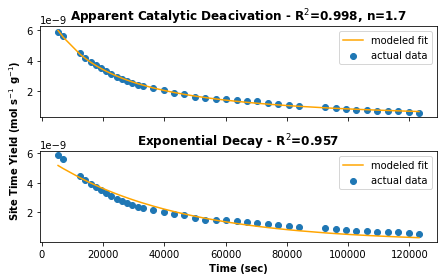

In [286]:
fig,[ax1,ax2] = plt.subplots(2,1,sharex=True)


ax1.plot(time,funcapp(time,*popt5_1)*scale5,label='modeled fit',color='orange')
ax1.scatter(time,c5*scale5,label='actual data')
ax1.set_title('Apparent Catalytic Deacivation - R$^2$={0:.3f}, n={1:.1f}'.format(r1,popt5_1[-1]),weight='bold')
ax1.legend()

ax2.plot(time,expdec(time,*popt5_2)*scale5,label='modeled fit',color = 'orange')
ax2.scatter(time,c5*scale5,label='actual data')
ax2.set_title('Exponential Decay - R$^2$={0:.3f}'.format(r2),weight='bold')
ax2.set_xlabel('Time (sec)',weight='bold')
ax2.legend()

fig.text(-0.02,0.5,'Site Time Yield (mol s$^{-1}$ g$^{-1}$)',weight='bold',va='center',rotation='vertical')

plt.tight_layout()
plt.show()

Just for fun, we will plot all the data with the modeled fits to see how they look.

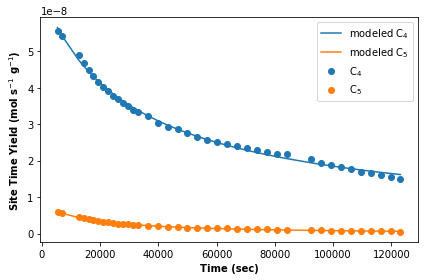

In [288]:
plt.scatter(time,c4*scale4,label='C$_{4}$')
plt.plot(time,funcapp(time,*popt4_1)*scale4,label='modeled C$_4$')
plt.scatter(time,c5*scale5,label='C$_{5}$')
plt.plot(time,funcapp(time,*popt5_1)*scale5,label='modeled C$_5$')
plt.xlabel('Time (sec)',weight='bold')
plt.ylabel('Site Time Yield (mol s$^{-1}$ g$^{-1}$)',weight='bold')
plt.tight_layout()
plt.legend()
plt.show()